# <center> 4인조 회귀분석 발표 </center>
## <center> 권효준, 이수정, 임정주, 현승우 </center>

# <center> House Prices: Advanced Regression Techniques </center>

# 프로젝트 주제 요약

## - 주제: House Prices (Kaggle competition)
## - 목표: SalePrice 변수 값 예측하기
## - 데이터 구성: 

    - 81개의 변수 (35 + 44 + 1 + 1)
        - 35개의 연속형 데이터
        - 44개의 범주형 데이터
        - ID(식별자)
        - 최종적으로 예측할 SalePrice(미국 IOWA주 집 거래 가격을 USD 단위로 나타낸 변수)
    - train data : 1460개의 샘플
    - test data : 1459개의 샘플

# 프로젝트 목표

## - Kaggle submission score를 올리는 것(RMSE를 최소화)

# 프로젝트 결과물

# Normalization과 LASSO regularization을 통한 결과값은 다음과 같다.

## kaggle competition
$$score = \frac{1}{n}\sqrt{\sum (\log(y) - \log(\hat{y}))^2}$$

![scoreimg](score.png)

## KFold를 사용해 실제 집값과 예측한 집값은 다음과 같이 나타낼 수 있다.

## root of MeanSquaredLoss(using KFold) = 31546

![scatterplotimg](download-1.png)

# 프로세스

## 0. 프로젝트에 필요한 패키지 설치 및 설정
## 1. 변수소개
## 2. 전처리
## 3. OLS
## 4. Scaling : Normalization
## 5. LASSO Regulization
## 6. Final OLS
## 7. 결과

## 0. 프로젝트에 필요한 패키지 설치 및 설정

In [49]:
try:
    import pandas as pd
except:
    ! pip3 install pandas
    import pandas as pd

In [50]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
try:
    import seaborn as sns
except:
    ! pip3 install seaborn
    import seaborn as sns
try:
    import matplotlib as plt
    import matplotlib.pylab as plt
except:
    ! pip3 install matplotlib
    import matplotlib as plt
    import matplotlib.pylab as plt

In [51]:
try:
    import numpy as np
except:
    ! pip3 install numpy
    import numpy as np

try:
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
except:
    ! pip3 install scikit-learn
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

try:
    import statsmodels
    from statsmodels.formula.api import ols
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except:
    ! pip3 install statsmodels
    import statsmodels
    from statsmodels.formula.api import ols
    from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. 변수 소개

- 데이터 구성: 
    - 81개의 변수 (35 + 44 + 1 + 1)
        - 35개의 연속형 데이터
        - 44개의 범주형 데이터
        - ID(식별자)
        - 최종적으로 예측할 SalePrice(미국 IOWA주 집 거래 가격을 USD 단위로 나타낸 변수)
    - train data : 1460개의 샘플
    - test data : 1459개의 샘플


### 최종적으로 SalePrice에 영향을 미쳤던 상위 10개의 변수는 다음과 같다.


### 마이너스 영향을 미쳤던 변수들 :
- Condition2_PosN 
- KitchenQual_Gd
- PoolQC_Gd 


### 플러스 영향을 미쳤던 변수들 :  
- KitchenQual_Gd 
- Condition2_Norm  
- Street_Pave
- RoofMatl_WdShngl
- Neighborhood_StoneBr
- Neighborhood_NoRidge
- Neighborhood_NridgHt

# 2. 전처리

### 데이터 불러오기

In [52]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')

In [53]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 분석을 위해서 Id(식별자)는 drop 한다.

In [54]:
df = df.drop(["Id"], axis=1)
df_test = df_test.drop(["Id"], axis=1)

### 변수명 맨 앞에 숫자가 들어가면 오류가 나므로, 변수명을 바꿔준다

In [55]:
df = df.rename({"1stFlrSF": "FstFlrSF",
                "2ndFlrSF": "SndFlrSF",
                "3SsnPorch": "TSsnPorch"}, axis="columns")
df_test = df_test.rename({"1stFlrSF": "FstFlrSF",
                          "2ndFlrSF": "SndFlrSF",
                          "3SsnPorch": "TSsnPorch"}, axis="columns")

#### 연속형 데이터와 범주형 데이터를 df.types로 구분한다. 이때, 최종적으로 예측할 SalePrice는 제거해준다.

In [56]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

### 연속형 데이터

In [57]:
print(quantitative)

len(quantitative)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FstFlrSF', 'SndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'TSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


36

### 이 중, "MSSubClass" 라는 변수는 실수로 나누어져 있지만 범주형으로 구분해야 한다는 것을 변수탐색 과정을 통해 알 수 있었다.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
       참고 ) kaggle data desription

### 그렇기 때문에 연속형 변수에서 삭제하고, 범주형 데이터로 넣어준다. 

In [58]:
quantitative.remove('MSSubClass')

In [59]:
print(quantitative)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FstFlrSF', 'SndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'TSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


### 범주형 데이터

In [60]:
qualitative = qualitative + ["MSSubClass"]
print(qualitative)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']


## NaN값 알아보기

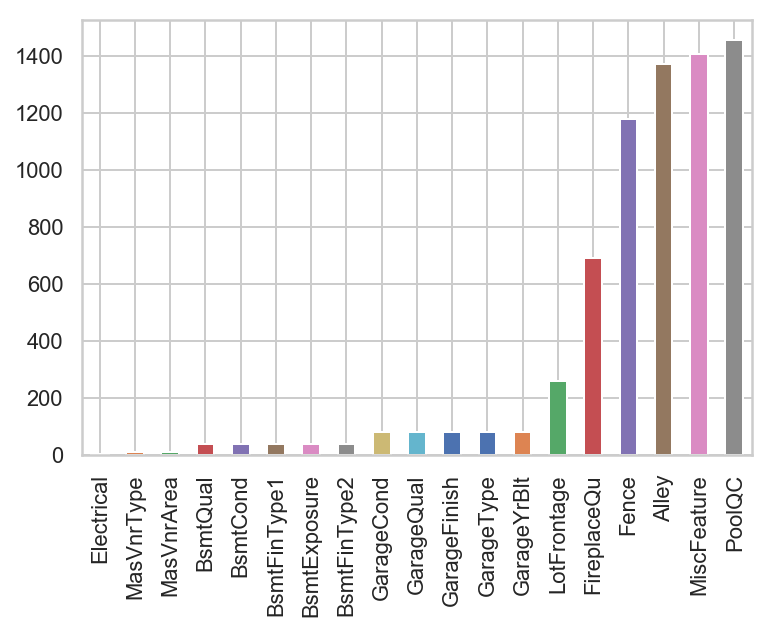

In [61]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### 데이터 탐색결과 NA 의 값이 missingvalue인것도 있었고, 속성값의 이름이 NA 인 것도 있었다. 예를들면 다음과 같다.

### NA값이 가장 많은 PoolQC의 변수명을 살펴보면, 

- PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
       
### NA는 missingvalue가 아니라 Pool이 없다는 것을 의미한다. 

### 현재 missingvalue를 확인한다

In [62]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

### 데이터 탐색을 통해 missingvalue가 아니라 na의 변수명이 있었던 것들은 'noexist'로 바꿔준다.

### 또한 연속형 변수에서도 missingvalue가 아니라 해당되는 변수의 값이 없었다는 의미를 0으로 바꿔주었다.

In [63]:
df[['Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']] = df[[
    'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']].fillna('noexist')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)  # 창고를 지은 년도를 설명하는 변수
df['LotFrontage'] = df['LotFrontage'].fillna(0)  # 도로와 직선으로 맞닿아 있는것을 설명하는 변수.

df_test[['Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']] = df[[
    'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond']].fillna('noexist')
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(0)  # 창고를 지은 년도를 설명하는 변수
# 도로와 직선으로 맞닿아 있는것을 설명하는 변수.
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(0)

### missing이라고 생각되는 값은 통계적 추론으로 대체한다.

In [64]:
df['BsmtExposure'][948] = "No"  # No라는 변수가 존재한다. 이를 사람이 실수하여 잘못 넣었다고 추정했다.
df['MasVnrType'] = df['MasVnrType'].fillna(
    df['MasVnrType'].mode().values[0])  # 최빈값
df['MasVnrArea'] = df['MasVnrArea'].fillna(np.mean(df["MasVnrArea"]))  # 평균값
df['Electrical'] = df['Electrical'].fillna(
    df['Electrical'].mode().values[0])  # 최빈값

df_test['MasVnrType'] = df_test['MasVnrType'].fillna(
    df['MasVnrType'].mode().values[0])  # 최빈값
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(
    np.mean(df["MasVnrArea"]))  # 평균값
df_test['Electrical'] = df_test['Electrical'].fillna(
    df['Electrical'].mode().values[0])  # 최빈값

### 다시 missingvalue를 확인한다. na값이 없음을 확인할 수 있다.

In [65]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

Series([], dtype: int64)

# 3. OLS

In [66]:
df_all = df.copy()
df_all_temp = pd.concat([df_all, df_test])
df_all_temp['MSSubClass'] = df_all_temp['MSSubClass'].astype('category')
df_temp = pd.get_dummies(df_all_temp)['MSSubClass_20']
df_all_temp = pd.get_dummies(df_all_temp, drop_first=True)
df_all_temp.insert(loc=36, column='MSSubClass_20', value=df_temp)
y_all = df_all_temp['SalePrice']
df_all_temp = df_all_temp.drop('SalePrice', axis=1)

df_all = df_all_temp.iloc[:1460, :]
y_all = y_all.iloc[:1460]
df_test_kaggle = df_all_temp.iloc[1460:, :]

In [67]:
result_all = sm.OLS(y_all, df_all).fit()
print(result_all.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     64.18
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        19:32:56   Log-Likelihood:                -16565.
No. Observations:                1460   AIC:                         3.366e+04
Df Residuals:                    1197   BIC:                         3.505e+04
Df Model:                         262                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
BedroomAbvGr          -3270.69

# 4. Scaling : Nomalization
## - loss가 89092에서 77219로 떨어졌음을 볼 수 있다

In [68]:
score = 0
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_all)):
    df_train, df_train_y = df_all.iloc[idx_train], y_all.iloc[idx_train]
    df_test, df_test_y = df_all.iloc[idx_test], y_all.iloc[idx_test]
    result_temp = sm.OLS(df_train_y, df_train).fit()
    yhat = result_temp.predict(df_test)
    temp_score = np.sqrt(mean_squared_error(df_test_y, yhat))
    score += temp_score
print(score/5)

89092.2414908864


In [69]:
df_norm = df_all.copy()
df_norm[quantitative] = (df_norm[quantitative] -
                         df_norm[quantitative].mean()) / df_norm[quantitative].std()
df_test_kaggle[quantitative] = (df_test_kaggle[quantitative] -
                                df_test_kaggle[quantitative].mean()) / df_test_kaggle[quantitative].std()
y_norm = y_all.copy()
score = 0
for i, (idx_train, idx_test) in enumerate(cv.split(df_norm)):
    df_train, df_train_y = df_norm.iloc[idx_train], y_norm.iloc[idx_train]
    df_test, df_test_y = df_norm.iloc[idx_test], y_norm.iloc[idx_test]
    result_norm = sm.OLS(df_train_y, df_train).fit()
    yhat = result_norm.predict(df_test)
    temp_score = np.sqrt(mean_squared_error(df_test_y, yhat))
    score += temp_score
print(score/5)

77219.45775890884


# 5. LASSO Reguralization

## - Train data와 kfold를 돌렸을 때의 loss값 차이가 많이 났음을 알 수 있다. 여기서 우리는 이 데이터가 과적합 되었을 가능성이 높다고 판단했다.
## - loss가 77219에서 31546까지 떨어졌음을 볼 수 있다.
## - Lasso와 Ridge중 Lasso가 결과값이 좋았으며 regularization term이 0.1일때 RMSE가 최저가 되는 것을 확인할 수 있다.

In [70]:
score = 0
df_norm_all = df_norm.copy()
y_norm_all = y_norm.copy()
result_norm = sm.OLS(y_norm_all, df_norm_all).fit()
yhat = result_norm.predict(df_norm_all)
score = np.sqrt(mean_squared_error(y_norm_all, yhat))
print(score)

20472.383788551513


In [71]:
regularization = [0, 1]
alpha = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
for r in regularization:
    for a in alpha:
        score = 0
        for i, (idx_train, idx_test) in enumerate(cv.split(df_norm)):
            df_train, df_train_y = df_norm.iloc[idx_train], y_norm.iloc[idx_train]
            df_test, df_test_y = df_norm.iloc[idx_test], y_norm.iloc[idx_test]
            result_reg = sm.OLS(df_train_y, df_train).fit_regularized(
                alpha=a, L1_wt=r)
            yhat = result_reg.predict(df_test)
            temp_score = np.sqrt(mean_squared_error(df_test_y, yhat))
            score += temp_score
        score /= 5
        print(a, r, score)
    print()

0.0001 0 39596.41047796486
0.0003 0 36291.1659528416
0.001 0 33601.18999844759
0.003 0 32207.688324636896
0.01 0 31545.697883839777
0.03 0 31658.316529282216
0.1 0 32615.39220633355

0.0001 1 47963.70426462027
0.0003 1 47963.91359956021
0.001 1 47963.27276160296
0.003 1 47961.72847542296
0.01 1 47977.588062433366
0.03 1 47942.663123223334
0.1 1 47937.02805070308



# 6. Final OLS

### 라쏘 모형의 alpha 값을 0.01로 설정해 준다.

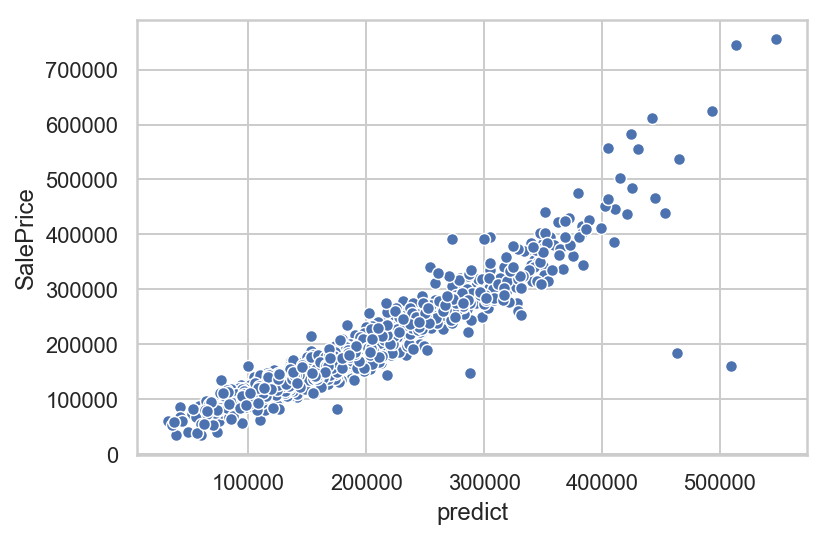

In [72]:
import matplotlib.pylab as plt
result_reg = sm.OLS(y_norm, df_norm).fit_regularized(alpha=0.01, L1_wt=0)
yhat = result_reg.predict(df_norm)
result_from = {'predicted': yhat, 'SalePrice': y_norm}
ax = sns.scatterplot(x="predicted", y="SalePrice", data=result_from)
plt.xlabel("predict")
plt.show()

# 7. 수치해석

In [73]:
most_relevant = np.argsort(np.absolute(result_reg.params))[-10:]

In [74]:
k = 0
for i in df_norm.columns[most_relevant]:
    print(i, result_reg.params[most_relevant][k])
    k += 1

Condition2_PosN -16958.75667647271
KitchenQual_Gd -17179.320489595357
PoolQC_Gd -17631.813535171226
Condition2_Norm 19346.23270058354
Street_Pave 20966.40680803261
PoolQC_noexist 22379.695009701827
Neighborhood_NridgHt 23528.936509755487
RoofMatl_WdShngl 24395.021988327317
Neighborhood_StoneBr 24797.924388486445
Neighborhood_NoRidge 26670.645354514152


## Kaggle에 제출

In [75]:
nan_list = df_test_kaggle.columns[df_test_kaggle.isna().any()].tolist()
for i in nan_list:
    df_test_kaggle[nan_list] = df_test_kaggle[nan_list].fillna(
        np.mean(df[nan_list]))

In [76]:
kaggle = result_reg.predict(df_test_kaggle)

In [77]:
kaggle_csv = pd.read_csv('sample_submission.csv')
kaggle_csv['SalePrice'] = kaggle

In [78]:
kaggle_csv.to_csv('submission.csv', index=False)